# Querying CosmoDC2 Mock v1 catalogs

This tutorial demonstrates how to access the CosmoDC2 Mock V1 catalogs. More information about these catalogs can be found here: https://irsa.ipac.caltech.edu/Missions/cosmodc2.html

These catalogs can be accessed through IRSA's Virtual Ovservatory Table Access Protocol (TAP) service. See https://www.ivoa.net/documents/TAP/ for details on the protocol. This service can be accessed through Python using the PyVO library.

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install numpy matplotlib pyvo

In [2]:
import pyvo as vo

In [3]:
service = vo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")

## List the available DC2 tables

In [4]:
tables = service.tables
for tablename in tables.keys():
    if not "tap_schema" in tablename:
        if "dc2" in tablename:
            tables[tablename].describe()

cosmodc2mockv1
    CosmoDC2MockV1 Catalog - unabridged, spatially partitioned

cosmodc2mockv1_heavy
    CosmoDC2MockV1 Catalog - stellar mass > 10^7 Msun

cosmodc2mockv1_new
    CosmoDC2MockV1 Catalog - unabridged


## Choose the DC2 catalog you want to work with.

IRSA currently offers 3 versions of the DC2 catalog.

* ``cosmodc2mockv1_new`` has been optimized to make searches with constraints on stellar mass and redshift fast.

* ``cosmodc2mockv1`` has been optimized to make searches with spatial constraints fast.

* ``cosmodc2mockv1_heavy`` is the same as ``cosmodc2mockv1_new``, except that it does not contain galaxies with stellar masses <= 10^7 solar masses.

If you are new to the DC2 catalog, we recommend that you start with ``cosmodc2mockv1_heavy``

In [5]:
# Choose the abridged table to start with.
# Queries should be faster on smaller tables.

tablename = 'cosmodc2mockv1_heavy'

## How many rows are in the chosen table?

With TAP, you can query catalogs with constraints specified in IVOA Astronomical Data Query Language (ADQL; https://www.ivoa.net/documents/latest/ADQL.html), which is based on SQL.

In [6]:
# For example, this snippet of ADQL counts the number of elements in
# the redshift column of the table we chose.
adql = f"SELECT count(redshift) FROM {tablename}"
adql

'SELECT count(redshift) FROM cosmodc2mockv1_heavy'

In [7]:
# In order to use TAP with this ADQL string using pyvo, you can do the following:
result = service.run_async(adql)
result

<DALResultsTable length=1>
count_redshift
    int64     
--------------
     597488849

The above query shows that there are 597,488,849 redshifts in this table. 
Running ``count`` on an entire table is an expensive operation, therefore we ran it asynchronously to avoid any potential timeout issues. 
To learn more about synchronous versus asynchronous PyVO queries please read the [relevant PyVO documentation](https://pyvo.readthedocs.io/en/latest/dal/index.html#synchronous-vs-asynchronous-query).

## What is the default maximum number of rows returned by the service?

This service will return a maximum of 2 billion rows by default.

In [8]:
service.maxrec

2000000000

This default maximum can be changed, and there is no hard upper limit to what it can be changed to.

In [9]:
print(service.hardlimit)

None


## List the columns in the chosen table

This table contains 301 columns.

In [10]:
columns = tables[tablename].columns
print(len(columns))

301


Let's learn a bit more about them.

In [11]:
for col in columns:
    print(f'{f"{col.name}":30s}  {col.description}')

ra                              Right ascension, lensed
dec                             Declination, lensed
ra_true                         Right ascension, not lensed
dec_true                        Declination, not lensed
redshift                        Cosmological redshift with line-of-sight motion
redshift_true                   Cosmological redshift
mag_u_lsst                      Apparent magnitude, lensed, in 'u' with LSST
mag_g_lsst                      Apparent magnitude, lensed, in 'g' with LSST
mag_r_lsst                      Apparent magnitude, lensed, in 'r' with LSST
mag_i_lsst                      Apparent magnitude, lensed, in 'i' with LSST
mag_z_lsst                      Apparent magnitude, lensed, in 'z' with LSST
mag_y_lsst                      Apparent magnitude, lensed, in 'y' with LSST
mag_u_sdss                      Apparent magnitude, lensed, in 'u' with SDSS
mag_g_sdss                      Apparent magnitude, lensed, in 'g' with SDSS
mag_r_sdss                

## Create a histogram of redshifts

Let's figure out what redshift range these galaxies cover. Since we found out above that it's a large catalog, we can start with a spatial search over a small area of 0.1 deg. The ADQL that is needed for the spatial constraint is:

In [12]:
adql = f"SELECT redshift FROM {tablename} WHERE CONTAINS(POINT('ICRS', RAMean, DecMean), CIRCLE('ICRS',54.218205903,-37.497959343,.1))=1"
adql

"SELECT redshift FROM cosmodc2mockv1_heavy WHERE CONTAINS(POINT('ICRS', RAMean, DecMean), CIRCLE('ICRS',54.218205903,-37.497959343,.1))=1"

Now we can use the previously-defined service to execute the query with the spatial contraint.

In [13]:
cone_results = service.run_sync(adql)

Text(0.5, 1.0, 'Redshift Histogram CosmoDC2 Mock Catalog V1 abridged')

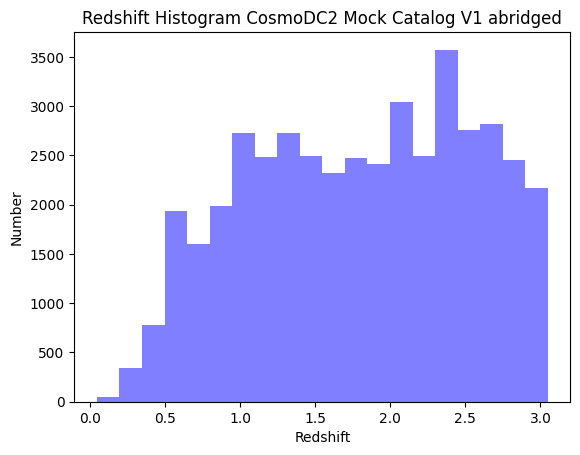

In [14]:
# Plot a histogram
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(cone_results['redshift'], num_bins,
                            facecolor='blue', alpha = 0.5)
plt.xlabel('Redshift')
plt.ylabel('Number')
plt.title('Redshift Histogram CosmoDC2 Mock Catalog V1 abridged')

We can easily see form this plot that the simulated galaxies go out to z = 3.

## Visualize galaxy colors at z ~ 0.5

Now let's visualize the galaxy main sequence at z = 2.0. First, we'll do a narrow redshift cut with no spatial constraint.

Let's do it as an asynchronous search since this might take awhile, too.

In [15]:
service = vo.dal.TAPService("https://irsa.ipac.caltech.edu/TAP")
adql = f"SELECT Mag_true_r_sdss_z0, Mag_true_g_sdss_z0, redshift FROM {tablename} WHERE redshift > 0.5 and redshift < 0.54"
results = service.run_async(adql)

In [16]:
len(results['mag_true_r_sdss_z0'])

3833489

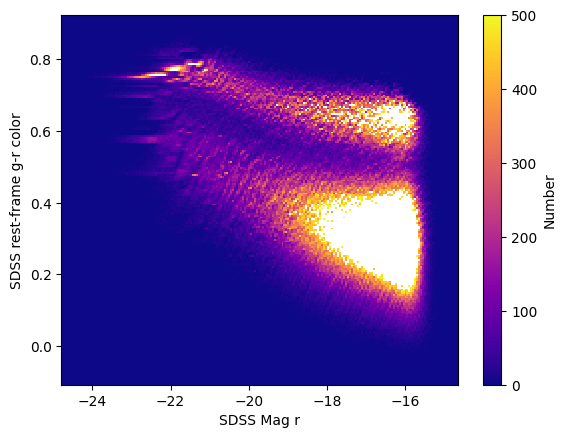

In [17]:
# Since this results in almost 4 million galaxies,
# we will construct a 2D histogram rather than a scatter plot.
plt.hist2d(results['mag_true_r_sdss_z0'], results['mag_true_g_sdss_z0']-results['mag_true_r_sdss_z0'],
           bins=200, cmap='plasma', cmax=500)

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number')

# Add title and labels to plot.
plt.xlabel('SDSS Mag r')
plt.ylabel('SDSS rest-frame g-r color')

# Show the plot.
plt.show()

***

## About this notebook

**Author:** Vandana Desai (IRSA Science Lead)

**Updated:** 2024-07-24

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.